In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import explained_variance_score

In [2]:
poverty = pd.ExcelFile("est19all.xls")

In [3]:
data_pe = poverty.parse(skiprows=3)

In [4]:
data_pe = data_pe[['Postal Code','Name',
        'Poverty Percent, All Ages',
        'Median Household Income']].copy()
data_pe = data_pe[data_pe['Postal Code'] != 'US']

In [5]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
abbr = dict((y,x) for x,y in us_state_abbrev.items())

In [6]:
data_pe['STNAME'] = data_pe.apply(lambda x: abbr[x['Postal Code']], axis = 1)

In [7]:
data_pe = data_pe.rename(columns={'Name': 'CTYNAME'})
data_pe = data_pe[~data_pe['CTYNAME'].isin(list(us_state_abbrev.keys()))]

In [8]:
data_pe.head()

,Postal Code,CTYNAME,"Poverty Percent, All Ages",Median Household Income,STNAME
2,AL,Autauga County,12.1,58233,Alabama
3,AL,Baldwin County,10.1,59871,Alabama
4,AL,Barbour County,27.1,35972,Alabama
5,AL,Bibb County,20.3,47918,Alabama
6,AL,Blount County,16.3,52902,Alabama


In [9]:
race = pd.read_csv("cc-est2019-alldata.csv", encoding='latin-1', usecols = ['STNAME', 'CTYNAME', 'YEAR', 'TOT_POP', 
                                                                            'WA_MALE', 'WA_FEMALE',
                                                                           'BA_MALE', 'BA_FEMALE',
                                                                           'IA_MALE', 'IA_FEMALE',
                                                                           'AA_MALE', 'AA_FEMALE',
                                                                           'NA_MALE', 'NA_FEMALE',
                                                                           'H_MALE', 'H_FEMALE'])

In [10]:
race_data = race[race['YEAR'] == 12].copy()

In [11]:
# race_data

race_list = ['WA', 'BA', 'IA', 'AA', 'NA', 'H']
    
race_data = race_data.groupby(by = ['STNAME',"CTYNAME", "YEAR"]).sum()


In [12]:
temp = race_data['TOT_POP']
race_data = race_data.drop('TOT_POP', axis = 1)

In [13]:
for r in race_list:
    race_data[r] = race_data[f"{r}_MALE"] + race_data[f"{r}_FEMALE"]
    

race_data  = race_data.loc[:,~race_data.columns.str.endswith('MALE')]
race_data['MAJORITY'] = race_data.idxmax(axis = 1)
race_data['TOT_POP'] = temp
race_data = race_data.reset_index()

In [14]:
race_data['MAJORITY'].value_counts()

WA    2994
BA     111
IA      32
AA       3
NA       1
H        1
Name: MAJORITY, dtype: int64

In [15]:
race_data['YEAR'] = [2019]*len(race_data.index)

In [17]:
smr = race_data.merge(data_pe, how='inner', left_on = ['STNAME', 'CTYNAME'], right_on = ['STNAME', 'CTYNAME'])

In [18]:
smr.head()

,STNAME,CTYNAME,YEAR,WA,BA,IA,AA,NA,H,MAJORITY,TOT_POP,Postal Code,"Poverty Percent, All Ages",Median Household Income
0,Alabama,Autauga County,2019,85214,22474,532,1312,116,3342,WA,111738,AL,12.1,58233
1,Alabama,Baldwin County,2019,390396,39186,3484,4760,308,21068,WA,446468,AL,10.1,59871
2,Alabama,Barbour County,2019,24268,23812,340,232,104,2234,WA,49372,AL,27.1,35972
3,Alabama,Bibb County,2019,34382,9526,206,96,52,1246,WA,44788,AL,20.3,47918
4,Alabama,Blount County,2019,110824,1956,740,370,134,11164,WA,115652,AL,16.3,52902


In [21]:
deaths = pd.read_csv("deaths_county_level.csv")
deaths.head()

,Date as of,First week,Last week,State,County name,FIPS County Code,Urban Rural Code,Deaths involving COVID-19,Deaths from All Causes
0,12/09/2020,02/01/2020,12/05/2020,AK,Anchorage Borough,2020,Medium metro,75,1798
1,12/09/2020,02/01/2020,12/05/2020,AK,Fairbanks North Star Borough,2090,Small metro,18,441
2,12/09/2020,02/01/2020,12/05/2020,AL,Autauga County,1001,Medium metro,35,433
3,12/09/2020,02/01/2020,12/05/2020,AL,Baldwin County,1003,Small metro,100,1924
4,12/09/2020,02/01/2020,12/05/2020,AL,Barbour County,1005,Noncore,17,239


In [22]:
deaths = deaths[['State', 'County name', 'Deaths involving COVID-19', 'Deaths from All Causes']]
deaths = deaths.rename(columns = {'Deaths involving COVID-19': 'covid_death', 'Deaths from All Causes': 'all_death'})
deaths.head()

,State,County name,covid_death,all_death
0,AK,Anchorage Borough,75,1798
1,AK,Fairbanks North Star Borough,18,441
2,AL,Autauga County,35,433
3,AL,Baldwin County,100,1924
4,AL,Barbour County,17,239


In [23]:
dd = smr.merge(deaths, how = 'inner', left_on = ['Postal Code', 'CTYNAME'], right_on = ['State', 'County name'])
dd.head()

,STNAME,CTYNAME,YEAR,WA,BA,IA,AA,NA,H,MAJORITY,TOT_POP,Postal Code,"Poverty Percent, All Ages",Median Household Income,State,County name,covid_death,all_death
0,Alabama,Autauga County,2019,85214,22474,532,1312,116,3342,WA,111738,AL,12.1,58233,AL,Autauga County,35,433
1,Alabama,Baldwin County,2019,390396,39186,3484,4760,308,21068,WA,446468,AL,10.1,59871,AL,Baldwin County,100,1924
2,Alabama,Barbour County,2019,24268,23812,340,232,104,2234,WA,49372,AL,27.1,35972,AL,Barbour County,17,239
3,Alabama,Bibb County,2019,34382,9526,206,96,52,1246,WA,44788,AL,20.3,47918,AL,Bibb County,20,163
4,Alabama,Blount County,2019,110824,1956,740,370,134,11164,WA,115652,AL,16.3,52902,AL,Blount County,12,419


In [25]:
# plt.plot(group['Median Household Income'], group['covid_death'], d)

In [26]:
death_race = pd.read_csv("deaths_race.csv")

In [27]:
death_race.head()

,Data as of,Start Week,End Week,State,Indicator,Non-Hispanic White,Non-Hispanic Black or African American,Non-Hispanic American Indian or Alaska Native,Non-Hispanic Asian,Non-Hispanic Native Hawaiian or Other Pacific Islander,Hispanic or Latino,Other,Footnote
0,12/09/2020,02/01/2020,12/05/2020,United States,Count of COVID-19 deaths,148043.0,47617.0,2851.0,9690.0,477.0,50710.0,2142.0,NaN
1,12/09/2020,02/01/2020,12/05/2020,United States,Distribution of COVID-19 deaths (%),56.6,18.2,1.1,3.7,0.2,19.4,0.8,NaN
2,12/09/2020,02/01/2020,12/05/2020,United States,Unweighted distribution of population (%),60.1,12.5,0.7,5.8,0.2,18.5,2.2,NaN
3,12/09/2020,02/01/2020,12/05/2020,United States,Weighted distribution of population (%),40.7,15.1,0.3,9.6,0.1,32.1,2.0,NaN
4,12/09/2020,02/01/2020,12/05/2020,Alabama,Count of COVID-19 deaths,2956.0,1539.0,NaN,23.0,0.0,106.0,NaN,One or more data cells have counts between 1-9...


In [28]:
death_race = death_race[['State', 'Indicator', 
                         'Non-Hispanic White', 'Non-Hispanic Black or African American', 
                         'Non-Hispanic American Indian or Alaska Native',
                        'Non-Hispanic Asian',
                        'Non-Hispanic Native Hawaiian or Other Pacific Islander',
                        'Hispanic or Latino',
                        'Other']]
death_race = death_race[death_race['State'] != 'United States']
death_race = death_race.replace(np.nan, 0)

In [29]:
death_race = death_race[death_race['Indicator'] == 'Distribution of COVID-19 deaths (%)']
# death_race = death_race[death_race['Indicator'] == 'Count of COVID-19 deaths']

In [30]:
state_population = race.groupby('STNAME').sum().reset_index()[['STNAME', 'TOT_POP']]

In [31]:
median_income = pd.ExcelFile('est19us.xls').parse(skiprows=3)
median_income = median_income[['Name', 'Median Household Income']]
# median_income = median_income[['Name', 'Poverty Percent, All Ages']]

In [32]:
smr2 = state_population.merge(median_income, left_on = ['STNAME'], right_on=['Name'], how='inner')

In [33]:
smr2 = smr2.merge(death_race, left_on = ['STNAME'], right_on = ['State'], how = 'inner')

In [34]:
smr2.columns

Index(['STNAME', 'TOT_POP', 'Name', 'Median Household Income', 'State',
       'Indicator', 'Non-Hispanic White',
       'Non-Hispanic Black or African American',
       'Non-Hispanic American Indian or Alaska Native', 'Non-Hispanic Asian',
       'Non-Hispanic Native Hawaiian or Other Pacific Islander',
       'Hispanic or Latino', 'Other'],
      dtype='object')

In [35]:
matplotlib.rcParams["font.size"] = 12

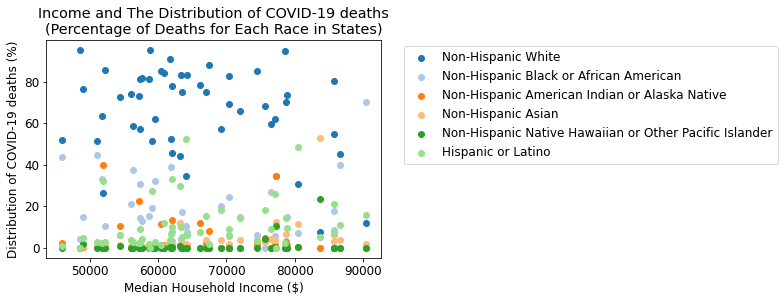

In [36]:
group = ['Non-Hispanic White',
       'Non-Hispanic Black or African American',
       'Non-Hispanic American Indian or Alaska Native', 'Non-Hispanic Asian',
       'Non-Hispanic Native Hawaiian or Other Pacific Islander',
       'Hispanic or Latino']
fig, ax = plt.subplots()
points = []
for i in range(len(group)):
    points.append(ax.scatter(smr2['Median Household Income'], smr2[group[i]], color = plt.cm.tab20(i)))
#     points.append(ax.scatter(smr2['Poverty Percent, All Ages'], smr2[group[i]], color = plt.cm.tab20(i)))
#     ax.legend(points)
# ax.legend()
ax.set_xlabel('Median Household Income ($)')
ax.set_ylabel('Distribution of COVID-19 deaths (%)')
ax.set_title("""Income and The Distribution of COVID-19 deaths
(Percentage of Deaths for Each Race in States)""")
lg = ax.legend(handles = points, labels = group, loc = 'best', bbox_to_anchor=(1.05, 1))
fig.savefig('Figure1.png', bbox_extra_artists=(lg,), bbox_inches='tight')

In [37]:
pca_data = dd[['WA', 'BA', 'IA', 'AA', 'NA', 'H', 'Median Household Income', 'covid_death']]

In [38]:
train, test = train_test_split(pca_data, train_size = 0.7)

In [39]:
# dir(pca)
explained_var = list()
for i in range(len(train.columns)):
    pca = PCA(n_components = i)
    pca.fit(pca_data)
    pca.transform(pca_data)
    explained_var.append([i, sum(pca.explained_variance_ratio_)])

In [40]:
# dir(pca)
scaled = StandardScaler().fit(train).transform(train)
explained_var_scaled = list()
for i in range(len(train.columns)):
    pca = PCA(n_components = i)
    pca.fit(pca_data)
    pca.transform(pca_data)
    explained_var_scaled.append([i, sum(pca.explained_variance_ratio_)])

In [41]:
pca_exl_var = pd.DataFrame(explained_var, columns = ['Components', 'Explained Variance'])
pca_exl_var_scaled = pd.DataFrame(explained_var_scaled, columns = ['Components', 'Explained Variance'])

Text(0, 0.5, 'Cumulative Explained Variance')

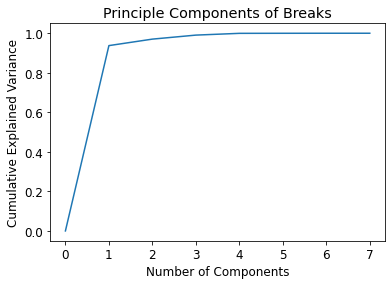

In [42]:
fig2, ax2 = plt.subplots()
line1 =  ax2.plot(pca_exl_var["Components"], pca_exl_var['Explained Variance'])
ax2.set_xlabel("Number of Components")
ax2.set_title("Principle Components of Breaks")
ax2.set_ylabel("Cumulative Explained Variance")
# line2 = ax2.scatter(pca_exl_var_scaled["Components"], pca_exl_var_scaled['Explained Variance'], color = plt.cm.tab20(3))

In [541]:
# fig.savefig(dpi=200, fname = 'Figure1.png')
# fig2.savefig(dpi=200, fname = 'Figure2.png')
# dir(pca)

In [43]:

# pf = PolynomialFeatures()
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ('pca', PCA(n_components = 3)),
    ('poly', PolynomialFeatures(degree = 2)),
    ("lr", LinearRegression())
])

In [44]:
y = 'covid_death'
pipe.fit(X = train, y = train[[y]])
# lr.fit(train, train[[y]])

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=3)),
                ('poly', PolynomialFeatures()), ('lr', LinearRegression())])

In [45]:
explained_variance_score(train[y], pipe.predict(train)), explained_variance_score(test[y], pipe.predict(test))

(0.9120244759857679, 0.8975793013704549)

In [48]:
# x = pipe['pca'].explained_variance_ratio_
a = pipe['lr'].coef_
# b = pipe['lr'].intercept_
coefficients = [x[0] for x in list(pipe['lr'].coef_[0].reshape(-1,1))]
coefficients = coefficients[1:]
# coef = pd.DataFrame(zip(pipe['poly'].get_feature_names(), coefficients), columns = ['coef','values'])
# coefficients
a.round(1)
# coefficients.round(1)

array([[   0. ,  166.5, -166.4, -156.1,    0.9,    5.9,   -9.8,   -7.3,
           1. ,   22.7]])

Text(0.5, 1.0, 'Linear Regression Coefficients')

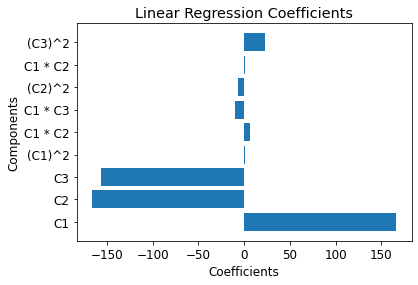

In [49]:
fig3, ax3 = plt.subplots()
ticks = ['C1', 'C2', 'C3', '(C1)^2',
 'C1 * C2', 'C1 * C3', '(C2)^2',
 'C1 * C2', '(C3)^2']
idx = range(len(coefficients))
ax3.barh(idx, coefficients)
plt.yticks(idx, ticks)
ax3.set_xlabel('Coefficients')
ax3.set_ylabel('Components')
ax3.set_title('Linear Regression Coefficients')

In [622]:
fig3.savefig(dpi=200,fname='Figure3.png', bbox_inches='tight')

In [50]:
pipe['poly'].get_feature_names()
['1', 'Component 1', 'Component 2', 'Component 3', '(Component 1)^2',
 'Component1 * Component 2', 'Component1 * Component 3', '(Component 2)^2',
 'Component1 * Component 2', '(Component 3)^2']

['1',
 'Component 1',
 'Component 2',
 'Component 3',
 '(Component 1)^2',
 'Component1 * Component 2',
 'Component1 * Component 3',
 '(Component 2)^2',
 'Component1 * Component 2',
 '(Component 3)^2']

In [51]:
pipe['pca'].components_, train.columns

(array([[ 0.42864018,  0.34489032,  0.38203468,  0.39885151,  0.24169599,
          0.41397448,  0.12256898,  0.38401856],
        [-0.02175059, -0.33884464, -0.06204399,  0.19615244,  0.48119535,
         -0.08463449,  0.73257817, -0.25884988],
        [-0.08024909, -0.30305055,  0.14500674,  0.17815501,  0.59766196,
          0.1045401 , -0.64679572, -0.24996228]]),
 Index(['WA', 'BA', 'IA', 'AA', 'NA', 'H', 'Median Household Income',
        'covid_death'],
       dtype='object'))